In [1]:
import json, os
import gensim
import gensim.downloader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from conlleval import evaluate

In [2]:
def dataset_preprocessor(dataset):
    preprocessed_data_list=[]

    for i in dataset:
        sentence_id=i["sentence_id"]
        sentence=i["sentence"]
        aspect_terms=i["aspect_terms"]
        
        tokens=[]      #will contain tuples of (token,token_start_index,token_end_index)
        curr_token=""
        curr_token_start_index=-1
        for j in range(len(sentence)):
            if curr_token=="":
                curr_token_start_index=j
            if sentence[j]==" ":       #if space is encountered, the token is complete
                if curr_token!="":        #remove blank token caused due to multiple spaces
                    tokens.append((curr_token,curr_token_start_index,j))
                    curr_token=""
            else:
                curr_token+=sentence[j]
        tokens.append((curr_token,curr_token_start_index,len(sentence)))
        
        labels=["O" for j in range(len(tokens))]
        aspect_terms_list=[]
        for j in aspect_terms:
            aspect_terms_list.append(j["term"])
            from_index=int(j["from"])
            to_index=int(j["to"])
            token_index=0
            
            token_index=0
            while token_index<(len(tokens)):
                if (from_index<=tokens[token_index][1] and tokens[token_index][1]<to_index) or (from_index>=tokens[token_index][1] and tokens[token_index][2]>=to_index):      
                    #1.If the token is completely inside the aspect term range mark it B, and check next token to mark as I (just in case aspect term is multiworded)
                    #2.If a single token somehhow encompasses full aspect range then some punctuation mark must be there and so just mark the whole token as B
                    labels[token_index]="B"
                    token_index+=1
                    while token_index<len(tokens) and tokens[token_index][1]<to_index:        #Checking next tokens and marking them as I until the aspect term range is covered
                        labels[token_index]="I"
                        token_index+=1
                else:
                    token_index+=1

        tokens_words=[i[0] for i in tokens]
        temp_dict={}
        temp_dict["sentence"]=sentence
        temp_dict["tokens"]=tokens_words
        temp_dict["labels"]=labels
        temp_dict["aspect_terms"]=aspect_terms_list

        # if sentence_id=="2846":
        #     print(temp_dict)
        #     print(tokens)
        preprocessed_data_list.append(temp_dict)
    return preprocessed_data_list


if not(os.path.exists("train_task_1.json")):
    dataset=json.load(open("train.json"))
    json.dump(dataset_preprocessor(dataset),open("train_task_1.json","w"))
if not(os.path.exists("val_task_1.json")):
    dataset=json.load(open("val.json"))
    json.dump(dataset_preprocessor(dataset),open("val_task_1.json","w"))


if not(os.path.exists("embedding_matrix_glove.npy") and os.path.exists("embedding_matrix_fasttext.npy")):
    #Downloading Glove and Fasttext embeddings :
    glove_model=gensim.downloader.load("glove-twitter-25")
    fasttext_model=gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [3]:
dataset=json.load(open("train_task_1.json"))
vocab={"<PAD>":0,"<UNK>":1}
for i in dataset:
    for j in i["tokens"]:
        if j.lower() not in vocab:
            vocab[j.lower()]=len(vocab)

vocab_to_id={v:k for k,v in vocab.items()}
# print("Vocab size:",len(vocab))
# print(vocab)

In [4]:
embedding_dim_glove=25#glove_model.vector_size
embedding_matrix_glove=np.zeros((len(vocab), embedding_dim_glove))         #Matrix to store embeddings of voacabulary words
embedding_dim_fasttext=300#fasttext_model.vector_size
embedding_matrix_fasttext=np.zeros((len(vocab), embedding_dim_fasttext))

if not(os.path.exists("embedding_matrix_glove.npy") and os.path.exists("embedding_matrix_fasttext.npy")):
    for word,idx in vocab.items():
        if word.strip(".!?,/;:'\"()") in glove_model:            #Ignoring punctuation marks to ensure that embeddings are found
            if word.strip(".!?,/;:'\"()")!="":
                embedding_matrix_glove[idx]=glove_model[word.strip(".!?,/;:'\"()")]
                # print(word.strip(".!?,/;:'\"()"),idx,embedding_matrix_glove[idx])
            else:
                # print(word,idx,embedding_matrix_glove[idx])
                embedding_matrix_glove[idx]=glove_model[word]

        if word.strip(".!?,/;:'\"()") in fasttext_model:
            if word.strip(".!?,/;:'\"()")!="":
                embedding_matrix_fasttext[idx]=fasttext_model[word.strip(".!?,/;:'\"()")]
            else:
                embedding_matrix_fasttext[idx]=fasttext_model[word]
    # for i in embedding_matrix_fasttext:
    #     print(i)
    np.save("embedding_matrix_glove.npy", embedding_matrix_glove)
    np.save("embedding_matrix_fasttext.npy", embedding_matrix_fasttext)
else:
    embedding_matrix_glove = np.load("embedding_matrix_glove.npy")
    embedding_matrix_fasttext = np.load("embedding_matrix_fasttext.npy")

In [5]:
class CustomDataset(Dataset):
    def __init__(self,data,vocab,max_token_length):
        self.data=data
        self.vocab=vocab
        self.max_len=max_token_length
        self.label_codes={"O":0,"B":1,"I":2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample=self.data[idx]
        tokens=sample["tokens"]
        labels=sample["labels"]
        token_indices=[self.vocab.get(token, self.vocab["<UNK>"]) for token in tokens]
        label_codes=[self.label_codes[label] for label in labels]

        pad_length=self.max_len-len(token_indices)
        if pad_length>0:
            token_indices+=[self.vocab["<PAD>"]]*pad_length
            label_codes+=[-1]*pad_length             #Creating separate padding label class helping ignore it later in the task

        return torch.tensor(token_indices),torch.tensor(label_codes)
    
train_dataset=json.load(open("train_task_1.json"))
val_dataset=json.load(open("val_task_1.json"))
max_length=max(max([len(i["tokens"]) for i in train_dataset]),max([len(i["tokens"]) for i in val_dataset]))
train_custom_dataset=CustomDataset(train_dataset,vocab,max_length)
val_custom_dataset=CustomDataset(val_dataset,vocab,max_length)
train_dataloader=DataLoader(train_custom_dataset,batch_size=32,shuffle=True)
val_dataloader=DataLoader(val_custom_dataset,batch_size=32,shuffle=False)

In [6]:
class RNN_Model(nn.Module):
    def __init__(self,embedding_matrix,embedding_dim,hidden_dimension):
        super(RNN_Model,self).__init__()
        self.embedding_layer=nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix),freeze=False)
        self.rnn=nn.RNN(input_size=embedding_dim,hidden_size=hidden_dimension,batch_first=True,bidirectional=False)
        self.fc=nn.Linear(hidden_dimension,3)

    def forward(self,x):
        x=self.embedding_layer(x)
        x,_=self.rnn(x)
        x=self.fc(x)
        return x

In [7]:
class GRU_Model(nn.Module):
    def __init__(self,embedding_matrix,embedding_dim,hidden_dimension):
        super(GRU_Model,self).__init__()
        self.embedding_layer=nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix),freeze=False)
        self.gru=nn.GRU(input_size=embedding_dim,hidden_size=hidden_dimension,batch_first=True,bidirectional=False)
        self.fc=nn.Linear(hidden_dimension,3)

    def forward(self,x):
        x=self.embedding_layer(x)
        x,_=self.gru(x)
        x=self.fc(x)
        return x

In [8]:
glove_RNN_model=RNN_Model(embedding_matrix_glove,embedding_dim_glove,hidden_dimension=128)
glove_GRU_model=GRU_Model(embedding_matrix_glove,embedding_dim_glove,hidden_dimension=128)
fasttext_RNN_model=RNN_Model(embedding_matrix_fasttext,embedding_dim_fasttext,hidden_dimension=256)
fasttext_GRU_model=GRU_Model(embedding_matrix_fasttext,embedding_dim_fasttext,hidden_dimension=256)

In [9]:
def train_model(model,train_dataloader,val_dataloader,epochs=10,lr=0.001,optimizer="Adam"):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model=model.to(device)
    criterion=nn.CrossEntropyLoss(ignore_index=-1)          #Ignoring padding labels
    if optimizer=="Adam":
        optimizer=optim.Adam(model.parameters(),lr=lr)
    elif optimizer=="SGD":
        optimizer=optim.SGD(model.parameters(),lr=lr)

    train_loss_history=[]
    val_loss_history=[]
    for epoch in range(epochs):
        model.train()
        total_loss=0
        for tokens,labels in train_dataloader:
            optimizer.zero_grad()      #Reset gradients so that each backward pass updates as per loss separately
            tokens,labels=tokens.to(device),labels.to(device)
            outputs=model(tokens)
            outputs=outputs.view(-1, outputs.shape[-1])  
            labels=labels.view(-1)

            loss=criterion(outputs,labels)
            loss.backward()            #Computes gradients
            optimizer.step()           #Updates weights as per loss
            total_loss+=loss.item()
        print(f"Epoch : {epoch+1}, Train Loss : {total_loss/len(train_dataloader)}.")
        train_loss_history.append(total_loss/len(train_dataloader))

        model.eval()              #Ensuring that model weights don't update with eval
        total_loss=0
        for tokens,labels in val_dataloader:
            tokens,labels=tokens.to(device),labels.to(device)
            outputs=model(tokens)
            outputs=outputs.view(-1, outputs.shape[-1])  
            labels=labels.view(-1)

            loss=criterion(outputs,labels)
            total_loss+=loss.item()
        print(f"Epoch : {epoch+1}, Val Loss : {total_loss/len(val_dataloader)}.")
        val_loss_history.append(total_loss/len(val_dataloader))

    return model,train_loss_history,val_loss_history

Stopping GLOVE models at 9th epoch and FASTTEXT models at 4th epoch as were overfitting after that with increasing val loss, decreasing trian loss.

Tried Learining Rate of 0.01 but got fluctuating losses, SGD but not low enough loss even with much more iterations, hence settled on ADAM with rate of 0.001.

In [10]:
model_results={}
for i,j in [(glove_RNN_model,"glove_RNN_model"),(glove_GRU_model,"glove_GRU_model"),(fasttext_RNN_model,"fasttext_RNN_model"),(fasttext_GRU_model,"fasttext_GRU_model")]:
    if "glove" in j:
        model,train_loss_history,val_loss_history=train_model(i,train_dataloader,val_dataloader,epochs=9,lr=0.001)
    else:
        model,train_loss_history,val_loss_history=train_model(i,train_dataloader,val_dataloader,epochs=3,lr=0.001)
    model_results[str(i)]=model,train_loss_history,val_loss_history
    torch.save(model,f"{j}.pth")

Epoch : 1, Train Loss : 0.38448186818655433.
Epoch : 1, Val Loss : 0.246709468960762.
Epoch : 2, Train Loss : 0.2291495089794134.
Epoch : 2, Val Loss : 0.1993123322725296.
Epoch : 3, Train Loss : 0.19700166379863565.
Epoch : 3, Val Loss : 0.17807865217328073.
Epoch : 4, Train Loss : 0.17566722994307418.
Epoch : 4, Val Loss : 0.1709679290652275.
Epoch : 5, Train Loss : 0.1582729152657769.
Epoch : 5, Val Loss : 0.16320414319634438.
Epoch : 6, Train Loss : 0.14478507995992512.
Epoch : 6, Val Loss : 0.1555350363254547.
Epoch : 7, Train Loss : 0.13583799751548023.
Epoch : 7, Val Loss : 0.15430607050657272.
Epoch : 8, Train Loss : 0.12725049445961978.
Epoch : 8, Val Loss : 0.15069790557026863.
Epoch : 9, Train Loss : 0.11616669191265261.
Epoch : 9, Val Loss : 0.1520340196788311.
Epoch : 1, Train Loss : 0.44047755893174706.
Epoch : 1, Val Loss : 0.27026601135730743.
Epoch : 2, Train Loss : 0.24963165374545307.
Epoch : 2, Val Loss : 0.21229263693094252.
Epoch : 3, Train Loss : 0.20498206621253

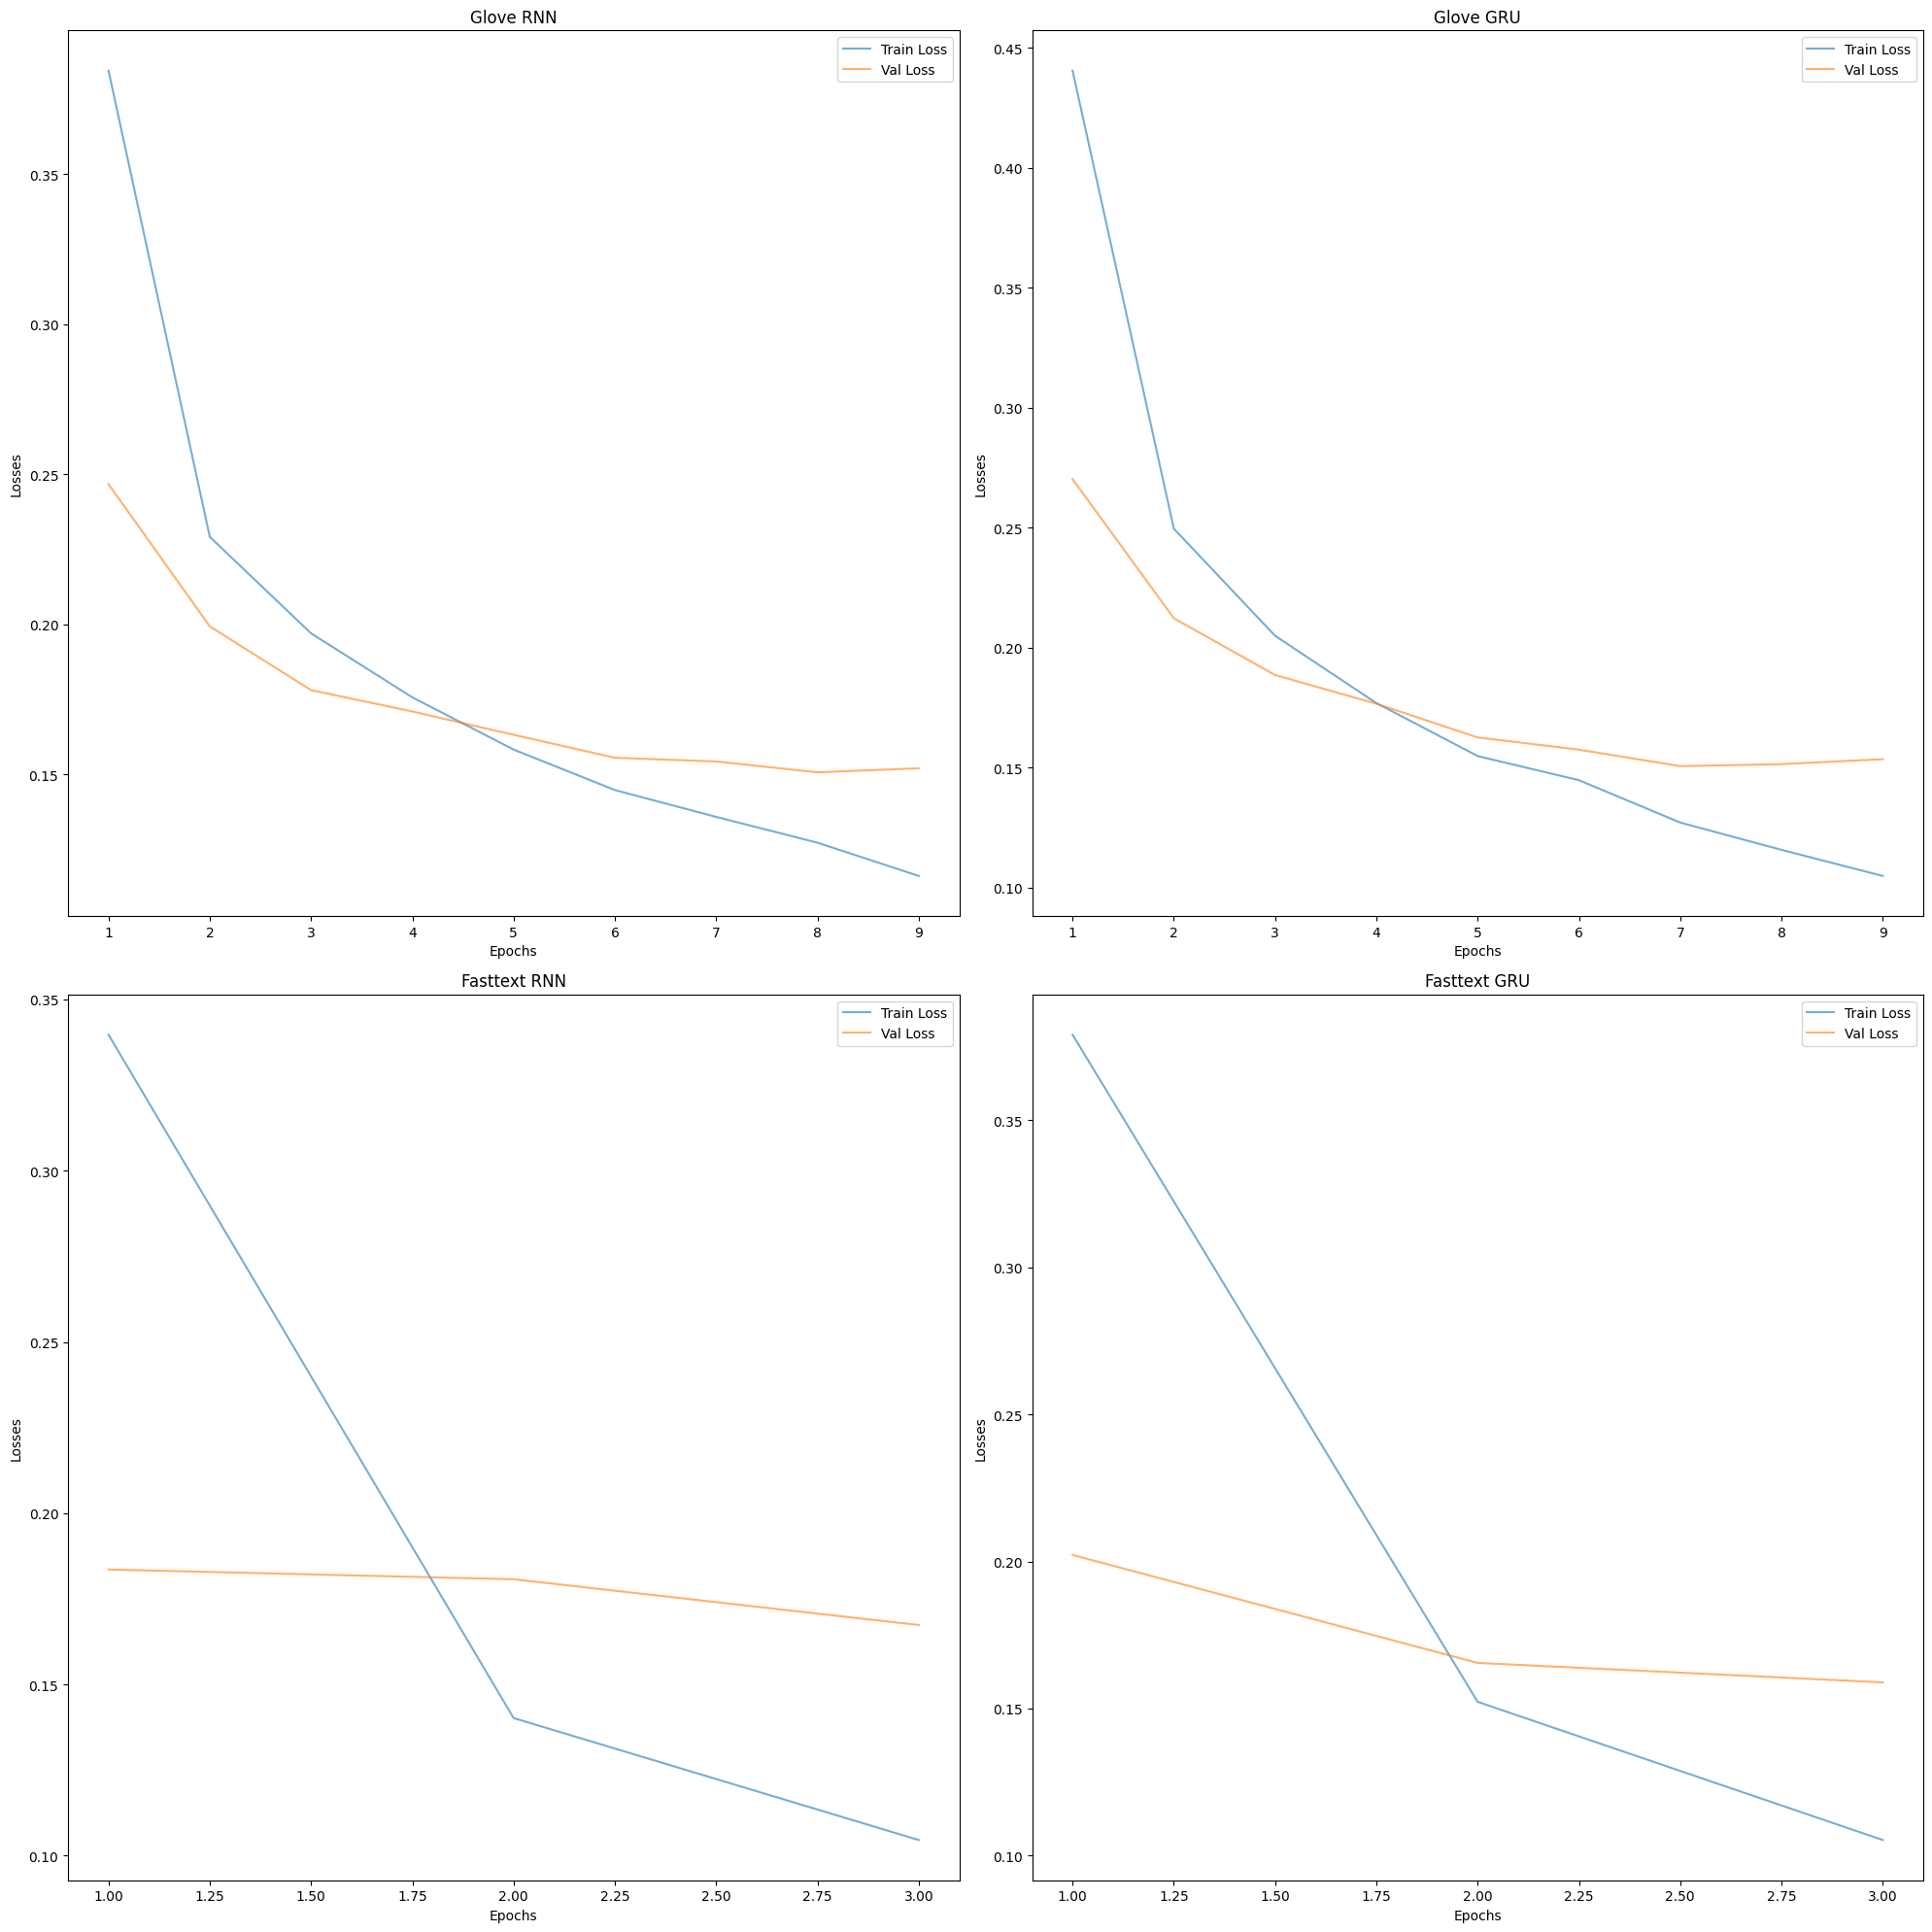

In [11]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
plt.plot(range(1,len(model_results[str(glove_RNN_model)][1])+1),model_results[str(glove_RNN_model)][1],label="Train Loss",alpha=0.6)
plt.plot(range(1,len(model_results[str(glove_RNN_model)][2])+1),model_results[str(glove_RNN_model)][2],label="Val Loss",alpha=0.6)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Glove RNN")
plt.legend()

plt.subplot(2,2,2)
plt.plot(range(1,len(model_results[str(glove_GRU_model)][1])+1),model_results[str(glove_GRU_model)][1],label="Train Loss",alpha=0.6)
plt.plot(range(1,len(model_results[str(glove_GRU_model)][2])+1),model_results[str(glove_GRU_model)][2],label="Val Loss",alpha=0.6)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Glove GRU")
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(1,len(model_results[str(fasttext_RNN_model)][1])+1),model_results[str(fasttext_RNN_model)][1],label="Train Loss",alpha=0.6)
plt.plot(range(1,len(model_results[str(fasttext_RNN_model)][2])+1),model_results[str(fasttext_RNN_model)][2],label="Val Loss",alpha=0.6)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Fasttext RNN")
plt.legend()

plt.subplot(2,2,4)
plt.plot(range(1,len(model_results[str(fasttext_GRU_model)][1])+1),model_results[str(fasttext_GRU_model)][1],label="Train Loss",alpha=0.6)
plt.plot(range(1,len(model_results[str(fasttext_GRU_model)][2])+1),model_results[str(fasttext_GRU_model)][2],label="Val Loss",alpha=0.6)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Fasttext GRU")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
def evaluate_model(model,dataloader):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model=model.to(device)
    model.eval()
    label_num_to_str_map={0:"O",1:"B",2:"I"}

    input_lst=[]
    with torch.no_grad():
        for tokens,labels in dataloader:
            tokens,labels = tokens.to(device),labels.to(device)
            outputs=model(tokens)
            outputs=torch.argmax(outputs, dim=-1)           #Making outputs into tensor list
            
            for i in range(len(labels)):
                tokens_list=list(tokens[i].cpu().numpy())
                true_labels=list(labels[i].cpu().numpy())
                pred_labels=list(outputs[i].cpu().numpy())
                true_labels=[label_num_to_str_map[j] for j in true_labels if j!=-1]           #Ignorning padding labels from evaluation
                lenght=len(true_labels)
                pred_labels=[label_num_to_str_map[pred_labels[j]] for j in range(len(pred_labels)) if j<lenght]       #Ensuring pred and true labels list are of same size
                tokens_list=[vocab_to_id[j] for j in tokens_list if j!=0]          #Ignoring padding tokens from evaluation
                
                for j in range(len(tokens_list)):
                    input_lst.append(f"{tokens_list[j]} {true_labels[j]} {pred_labels[j]}")      #Conlleval evaluate wants input in the form of "word true_label predicted_label"

    output_frm_conlleval=evaluate(lines=input_lst)["overall"]
    f1_chunk_level=output_frm_conlleval["chunks"]["evals"]["f1"]
    f1_tags_level=output_frm_conlleval["tags"]["evals"]["f1"]
    # print(evaluate(lines=input_lst))
    return f1_chunk_level,f1_tags_level

glove_RNN_model=torch.load("glove_RNN_model.pth")
glove_GRU_model=torch.load("glove_GRU_model.pth")
fasttext_RNN_model=torch.load("fasttext_RNN_model.pth")
fasttext_GRU_model=torch.load("fasttext_GRU_model.pth")
models=[(glove_RNN_model,"glove_RNN_model"),(glove_GRU_model,"glove_GRU_model"),(fasttext_RNN_model,"fasttext_RNN_model"),(fasttext_GRU_model,"fasttext_GRU_model")]
for i,j in models:
    f1_chunk,f1_tags=evaluate_model(i,val_dataloader)
    print(f"Model : {j},  F1 Score(Chunk Level) : {f1_chunk}, F1 Score(Tags Level) : {f1_tags}")

C:\Users\nishi\AppData\Local\Temp\ipykernel_28160\1814660109.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  glove_RNN_model=torch.load("glove_RNN_model.pth")
C:\Users\

Model : glove_RNN_model,  F1 Score(Chunk Level) : 0.6560232220609579, F1 Score(Tags Level) : 0.9451447245564892
Model : glove_GRU_model,  F1 Score(Chunk Level) : 0.6877828054298644, F1 Score(Tags Level) : 0.9477124183006536
Model : fasttext_RNN_model,  F1 Score(Chunk Level) : 0.667621776504298, F1 Score(Tags Level) : 0.9409430438842203
Model : fasttext_GRU_model,  F1 Score(Chunk Level) : 0.6715116279069767, F1 Score(Tags Level) : 0.9451447245564892


Best Model is Glove GRU as per above F1 scores. We also observe that in general GRU models are better.

In [ ]:
glove_GRU_model=torch.load("glove_GRU_model.pth")

if not(os.path.exists("test_task_1.json")):
    dataset=json.load(open("test.json"))
    json.dump(dataset_preprocessor(dataset),open("test_task_1.json","w"))
test_dataset=json.load(open("test_task_1.json"))
test_custom_dataset=CustomDataset(test_dataset,vocab,max_length)
test_dataloader=DataLoader(test_custom_dataset,batch_size=32,shuffle=False)

f1_chunk,f1_tags=evaluate_model(glove_GRU_model,test_dataloader)
print(f"Test File... F1 Score(Chunk Level) : {f1_chunk}, F1 Score(Tags Level) : {f1_tags}")